## Теория:

## Causal inference и causal discovery

***Causal Inference*** - оценка эффекта от воздействия там, где зависимость уже есть

***Causal Discovery*** - поиск зависимости там, где мы не уверены, что есть зависимость

***Какие методики Causal inference муществуют?*** (Рассмотрим основные группы:)
* Рандомизированные a/b тесты - эталонный метод (выбираем его, если есть возможность)
* Counterfactuals analysis (анализ гипотетического поведения) (causal impact, syn diff in diff)
* Квази-эксперименты (diff in diff, Propensity score matching, regression discontinuity,
Instrumental variables) - квази потому что деление на группы происходить не рандомно, а может по региону, по платформе и пр.

***Почему не проводить только a/b тесты, если они - это лучшее решение?***
* требуется оценить эффект от фичи, которая уже работает длительное время, а провести обратный тест не является целесообразны решением
* невозможно провести эксперимент по этическим причина, например, a/b тесты лекарств
* невозможно провести a/b тест по техническим причинам
* мы не контролируем формирование контрольной группы (либо она с selected bias, либо просто не существует)

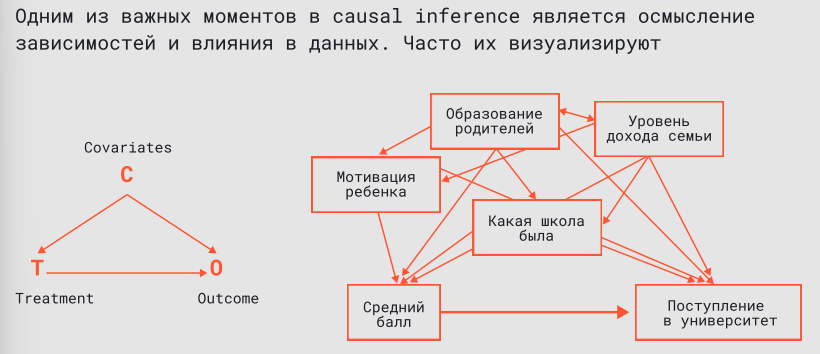

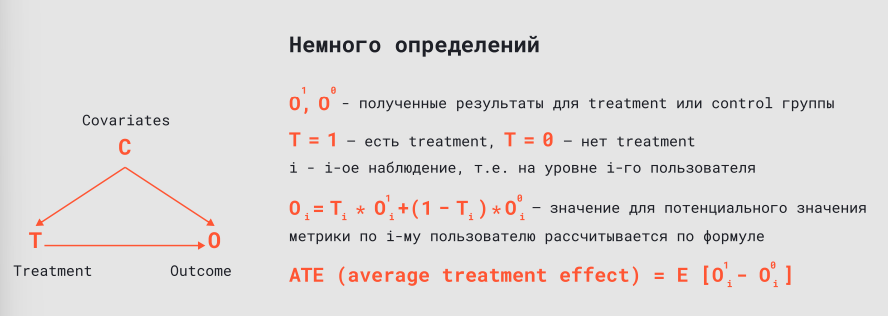

Ключевая проблема в том, что мы не можем наблюдать оба состояния для i-го наблюдения: и для T=1, и T=0

***Как работает a/b тест в causal inference?***
В A/B-тесте мы обходим основное ограничение Causal Inference,
т.к. при соблюдении условий можем перейти от подсчета разницы
для конкретного i наблюдения к усреднению по всем.

При соблюдении условий запуска A/B-теста такой подход дает  
нам несмещенную оценку истинного ATE.
$$ATE (average treatment effect) = E [O_1{i} - O_0{i} ]$$
Если же A/B-тест нельзя провести, мы любыми  
способами пытаемся учитывать информацию о ковариатах,  
т.к. иначе мы будем получать смещенную оценку ATE.

***Где используется Diff in diff (difference in difference)?***

* Для поиска эффектов, когда у нас нет рандомизированного разбиения на тестовую и контрольную группу

* Активно используется в макроэкономических, эконометрических и социальных исследованиях

* Методика работает с временными (панельными) данными (должен быть период до и после нововведения) для тестовой и контрольной группы

### Как работает diff in diff

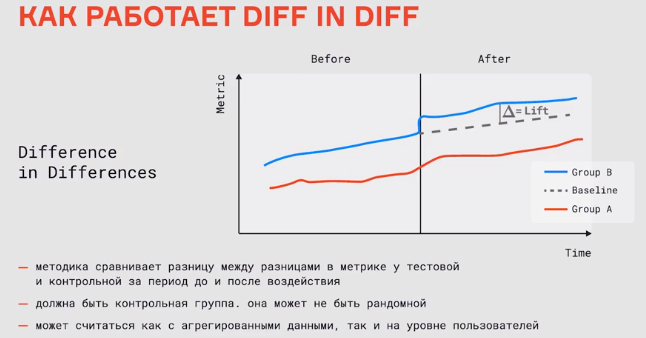

***Требования к методике:***
1. Логика разбиения на тест и контроль не должна быть связана с treatment
2. Тест и контроль должны иметь параллельные тренды
3. Не должно быть эффекта перетекания между тестом и контролем. Контрольная группа фиксирована, и в неё не "попадает" эффект из тестовой (пример - перетекание между кластерами платящего поведения)

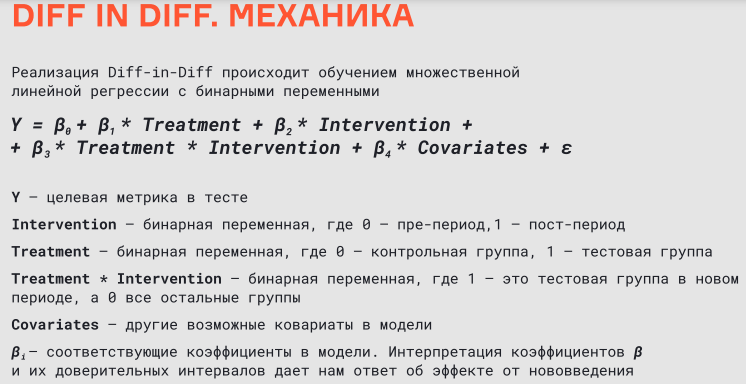

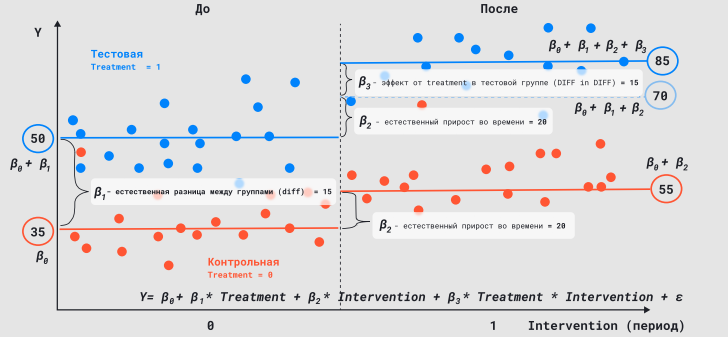

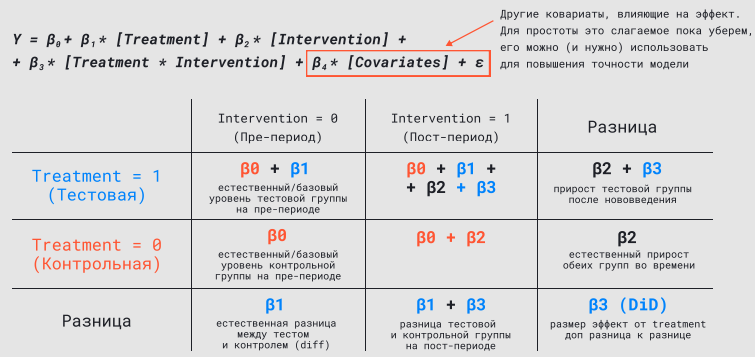

***Плюсы:***
* Простой в применении и интуитивно понятный
* Может работать с ретроспективными данными, в которых не было рандомного разделения на тест/контроль
* Может работать как с поюзерными данными, так и с агрегированными данными по группам
* Можно встраивать дополнительные ковариаты, уточняющие/очищающие эффект
* Могут сравниваться непохожие друг на друга группы (например, столицу можно сравнить с меньшим регионом)
* Можно использовать натуральное деление между группами (регионы, платформы и т.п.), что повышает интерпретируемость методики

***Минусы:***
* Необходимы исторические данные и группа, которая не испытывала воздействия в период эксперимента. Не получится применить, если все получили treatment
* Нельзя использовать, когда воздействие и разбиение на группы связаны
* Нельзя использовать, если тренды в двух группах не параллельны 
* Нельзя использовать, если группы до/после нестабильны

## Практика:

In [ ]:
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm
import statsmodels.api as smp
from scipy.stats import ttest_1samp
plt.style.use('ggplot')

# 1. Diff in diff. Поюзерный простой случай

In [ ]:
# создадим данные по заданным значениям и с определенным эффектом от нововведения
control_mean = 100
control_test_diff = 20
control_growth = 10
treatment_effect = 10

pre_data_control = np.random.normal(control_mean, 10, 100)
pre_data_test = np.random.normal(control_mean + control_test_diff, 10, 100)
post_data_control = np.random.normal(control_mean + control_growth, 10, 100)
post_data_test = np.random.normal(control_mean + control_growth + control_test_diff + treatment_effect, 10, 100)

pre_data_control = pd.DataFrame({'value': pre_data_control, 'treatment': 0, 'intervention': 0})
pre_data_test = pd.DataFrame({'value': pre_data_test, 'treatment': 1, 'intervention': 0})
post_data_control = pd.DataFrame({'value': post_data_control, 'treatment': 0, 'intervention': 1})
post_data_test = pd.DataFrame({'value': post_data_test, 'treatment': 1, 'intervention': 1})

data = pd.concat([pre_data_control, pre_data_test, post_data_control, post_data_test])
data

,value,treatment,intervention
0,101.958453,0,0
1,90.216272,0,0
2,104.082528,0,0
3,82.974164,0,0
4,110.291556,0,0
...,...,...,...
95,128.536546,1,1
96,143.026355,1,1
97,132.457241,1,1
98,139.358617,1,1


In [ ]:
# посмотрим как различаются данные на пост периоде
data.groupby(['treatment', 'intervention']).mean()

value
treatment intervention            
0         0             101.040183
          1             110.879240
1         0             122.303874
          1             141.192345

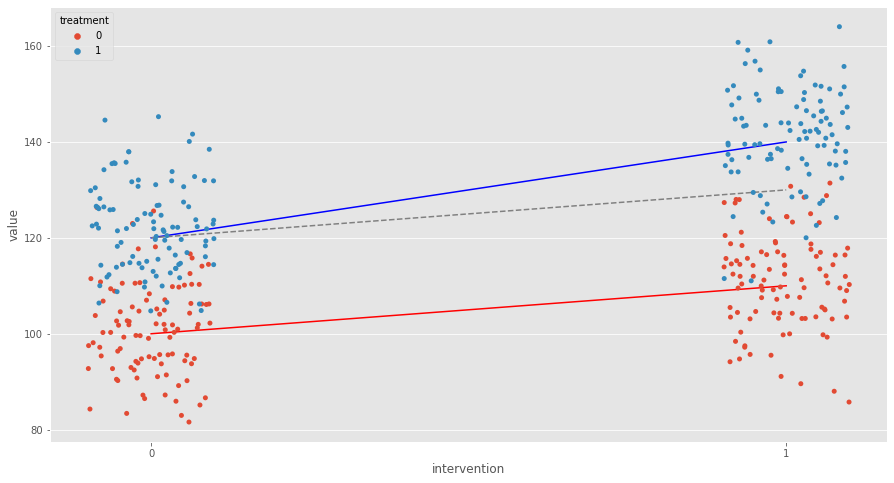

In [ ]:
plt.figure(figsize = (15, 8))
sns.stripplot(data, x = 'intervention', y ='value', hue = 'treatment')
plt.plot([0, 1], [control_mean, control_mean + control_growth], color = 'red')
plt.plot([0, 1], [control_mean + control_test_diff, control_mean + control_growth + control_test_diff + treatment_effect], color = 'blue')
# добавим counterfactual ряд
plt.plot([0, 1], [control_mean + control_test_diff, control_mean + control_growth + control_test_diff], color = 'grey', ls = '--')


Если бы мы просто посмотрели разницу на пост-периоде (в нашем случае она равно 140 - 110 = 30), то мы завысили бы истинный эффект в 3 раза. Т.к. не учитываем существующую разницу. Даже если бы настоящего эффекта не существовало, мы бы приняли за эффект обычно существующую разницу между  группами. Значительно увеличилась бы ошибка FP

In [ ]:
df_s = data.pivot_table(values = 'value', index = 'treatment', columns = 'intervention', aggfunc = 'mean')
df_s['diff'] = df_s.iloc[:, 1] - df_s.iloc[:, 0] # Вычисление разниц
diff_in_diff = df_s.iloc[1, -1] - df_s.iloc[0, -1] # Вычисление DiD

print('Expected effect (Diff-in-Diff) =', round(treatment_effect, 1))
print('Observed effect (Diff-in-Diff) =', round(diff_in_diff, 2))
round(df_s, 1)

Expected effect (Diff-in-Diff) = 10
Observed effect (Diff-in-Diff) = 9.05


intervention,0,1,diff
treatment,,,
0,101.0,110.9,9.8
1,122.3,141.2,18.9


In [ ]:
# теперь обучим модель регрессии на наших данных и посмотрим находит ли регрессия нужные значения
formula = 'value ~ treatment + intervention + treatment * intervention' # Формула Y с лекции без учета B0
model = sm.ols(formula = formula, data = data)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     314.3
Date:                Mon, 02 Oct 2023   Prob (F-statistic):          2.33e-104
Time:                        15:39:16   Log-Likelihood:                -1475.4
No. Observations:                 400   AIC:                             2959.
Df Residuals:                     396   BIC:                             2975.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                101

# 2. Diff in Diff для агрегированного случая (работа с временным рядом)
### 2.1 АА вариант

In [ ]:
# Генерируем синтетические временные данные на 1 год (2021) и с начала ноября будем считать что было изменение (intervention)
np.random.seed(42)

ar = np.r_[1, 0.2]
ma = np.array([1])
arma_process = ArmaProcess(ar, ma) # для большей правдоподобности создадим ARMA процесс

x0 = 100 + arma_process.generate_sample(nsample=365) # ковариата. Длительность временого ряда 365 дней. Наш контроль
y = 1.9 * x0 + np.random.normal(10, 5, size=365) # целевая метрика. Сильно коррелированая с кавариатой. Тестовая группа
data = pd.DataFrame({'x0': x0, 'y': y}, columns=['y', 'x0'])

date_range = pd.date_range(start="2021-01-01", periods = 365)
ts_data = data.copy()
ts_data.index = date_range
# Задаем изменение с 2021-11-01
ts_data['intervention'] = np.where(ts_data.index >= '2021-11-01', 1, 0)

ts_data.head()

,y,x0,intervention
2021-01-01,198.937655,100.496714,0
2021-01-02,200.669009,99.762393,0
2021-01-03,201.383861,100.695210,0
2021-01-04,203.117957,101.383988,0
2021-01-05,195.164144,99.489049,0


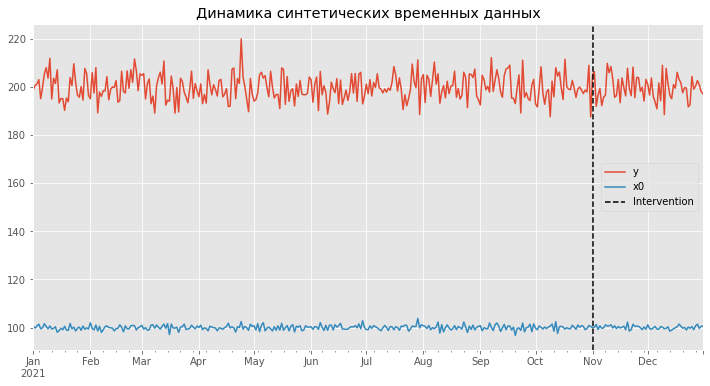

In [ ]:
# отрисуем ряд на графике
plt.figure(figsize = (12, 6))
ts_data.y.plot(label = 'y')
ts_data.x0.plot(label = 'x0')
plt.title('Динамика синтетических временных данных')
plt.axvline(x="2021-11-01", color='black', linestyle='--', label='Intervention')
plt.legend();

Смотрим динамику созданных временных данных для целевой y метрики и контрольной x0 метрики. Начиная с черной линии предположим, что произошли изменения, которые на метрику никак не повлияли.

### 2.2 Проверка на параллельность трендов
* Параллельность временого ряда = Стационарность разницы между тестовой и контрольной метрикой.
* Если тренды параллельны, тогда разница между двумя времеными рядами колебается вокруг какой-то константы и не зависит от времени.

#### Статистический критерий Дики-Фуллера проверяет стационарность временого ряда:

$\large H_0:$ ряд нестационарен

$\large H_1:$ ряд стационарен

p-value тест Дики-Фуллера = 0.000000
Разница между метрикой и ковариатой стационарна во времени? -> True


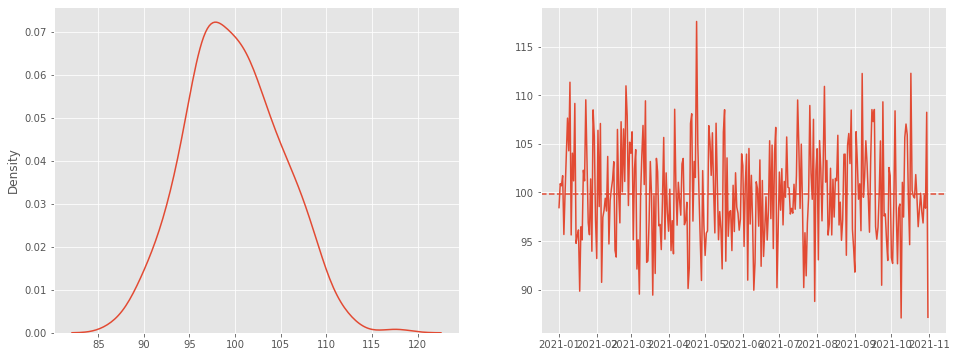

In [ ]:
y_pre = ts_data[ts_data['intervention'] == 0].y
x0_pre = ts_data[ts_data['intervention'] == 0].x0
diff = y_pre - x0_pre
DF_pval = smp.tsa.stattools.adfuller(diff)[1]
print("p-value тест Дики-Фуллера = %f" % DF_pval)
print('Разница между метрикой и ковариатой стационарна во времени? ->', DF_pval < 0.05)
fig,axes = plt.subplots(1, 2, figsize=(16,6))
sns.kdeplot(ax=axes[0], data = diff)
axes[1].plot(diff)
axes[1].axhline(y = np.mean(diff),ls = '--')

Как мы видим и по графику и по анализу Дика-Фуллера -  разница между рядами стационарна, значит мы можем предполагать паралельность трендов.
Поведение ряда при нестационарности разницы мы проиллюстрируем дальше.

In [ ]:
# проведем diff in diff анализ на агрегированных во времени данных. При этом помним, что никакого эффекта мы сюда не закладывали
data_w = pd.melt(ts_data.reset_index(), id_vars=['index', 'intervention'], value_vars=['y', 'x0'],
                 var_name='variable', value_name='value') # Приводим в удобный формат для анализа diff-in-diff
data_w['treatment'] = np.where(data_w.variable == 'y', 1, 0) # Обозначаем группу контрольная/тестовая
data_w.sample(10) # визуально посмотрим корректно ли присвоились бинарные переменные

,index,intervention,variable,value,treatment
728,2021-12-30,1,x0,100.479171,0
439,2021-03-16,0,x0,97.054383,0
484,2021-04-30,0,x0,100.477601,0
296,2021-10-24,0,y,199.250969,1
308,2021-11-05,1,y,199.502062,1
479,2021-04-25,0,x0,99.314585,0
92,2021-04-03,0,y,193.119689,1
434,2021-03-11,0,x0,99.325118,0
161,2021-06-11,0,y,193.796347,1
318,2021-11-15,1,y,203.235746,1


Приводим данные в удобный формат для анализа diff-in-diff

In [ ]:
df_s = data_w.pivot_table(values = 'value', index = 'treatment', columns = 'intervention', aggfunc = 'mean')
df_s['diff'] = df_s.iloc[:, 1] - df_s.iloc[:, 0] # Вычисление разниц

diff_in_diff = df_s.iloc[1, -1] - df_s.iloc[0, -1] # Вычисление DiD

diff_in_diff = df_s.iloc[1, -1] - df_s.iloc[0, -1]

print('Diff-in-Diff =', diff_in_diff)
df_s

Diff-in-Diff = -0.1260895642728599


intervention,0,1,diff
treatment,,,
0,99.995595,100.073172,0.077577
1,199.834301,199.785789,-0.048513


In [ ]:
# прогоним  данные через регрессию
formula = 'value ~ treatment + intervention + treatment * intervention' # Формула Y с лекции без учета B0
model = sm.ols(formula = formula, data = data_w)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                 4.137e+04
Date:                Mon, 02 Oct 2023   Prob (F-statistic):               0.00
Time:                        15:40:23   Log-Likelihood:                -2013.7
No. Observations:                 730   AIC:                             4035.
Df Residuals:                     726   BIC:                             4054.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 99

Применяем формулу с лекции без учета B_0 и случайной ошибки $ε$:

$Y= β_0 + β_1*[Treatment] + β_2*[Intervention] + β_3*[Treatment*Intervention] + β_4*[Covariates]+ε$

In [ ]:
# укажем p-value полученной оценки из модели регрессии
print('Diff-in-Diff =', res.params['treatment:intervention'])
print('p-value =', res.pvalues['treatment:intervention'])

Diff-in-Diff = -0.12608956427283413
p-value = 0.8681828485984326


### 2.3 АБ вариант Diff in Diff для агрегированного случая (работа с временным рядом)

In [ ]:
# Снова генерируем данные но теперь задаем эффект начиная с ноября, в виде относительного изменения +3%
np.random.seed(42)

ar = np.r_[1, 0.2]
ma = np.array([1])
arma_process = ArmaProcess(ar, ma)

x0 = 100 + arma_process.generate_sample(nsample=365)
y = 1.9 * x0 + np.random.normal(size=365)
data = pd.DataFrame({'x0': x0, 'y': y}, columns=['y', 'x0'])

date_range = pd.date_range(start="2021-01-01", periods = 365)
ts_data = data.copy()
ts_data.index = date_range

ts_pre_period = [pd.to_datetime(date) for date in ["2021-01-01", "2021-10-31"]]
ts_post_period = [pd.to_datetime(date) for date in ["2021-11-01", "2021-12-31"]] # post период начинаем с 1 ноября

ts_data.loc[ts_post_period[0]:ts_post_period[1], 'y'] *= 1.03 # добавляем эффект

ts_data['intervention'] = 0
ts_data.loc[ts_post_period[0]:ts_post_period[1], 'intervention'] = 1

ts_data.sample(20)

,y,x0,intervention
2021-11-15,197.016596,100.415197,1
2021-03-07,191.010579,101.154651,0
2021-01-01,190.542536,100.496714,0
2021-05-12,189.641621,100.357299,0
2021-01-24,188.174625,98.539053,0
2021-02-20,190.546139,100.681382,0
2021-10-08,190.104019,100.198285,0
2021-09-17,192.822831,100.647181,0
2021-06-04,191.163690,100.217002,0
2021-05-05,192.651921,100.931727,0


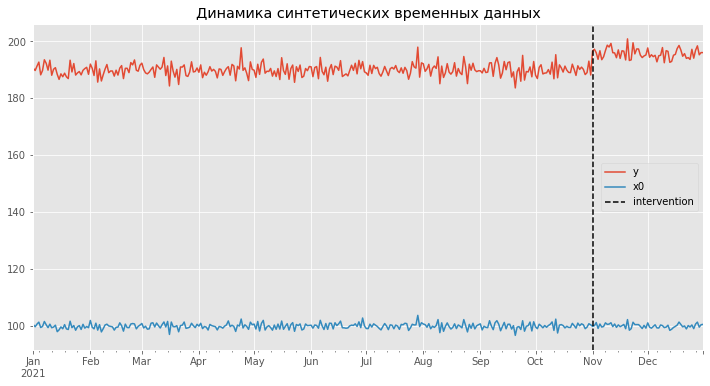

In [ ]:
plt.figure(figsize = (12, 6))
ts_data.y.plot(label = 'y')
ts_data.x0.plot(label = 'x0')
plt.title('Динамика синтетических временных данных')
plt.axvline(x="2021-11-01", color='black', linestyle='--', label='intervention')
plt.legend();

На графике можем теперь наблюдать, что с момента изменения значения для метрики y сдвинулись на +3%

In [ ]:
df_s

treatment,0,1,diff
intervention,,,
0,99.995595,189.960165,89.964570
1,100.073172,195.770431,95.697259


In [ ]:
data_w = pd.melt(ts_data.reset_index(), id_vars=['index', 'intervention'], value_vars=['y', 'x0'],
                 var_name='variable', value_name='value')
data_w['treatment'] = np.where(data_w.variable == 'y', 1, 0)

df_s = data_w.pivot_table(values = 'value', index = 'intervention', columns = 'treatment', aggfunc = 'mean')
df_s['diff'] = df_s.iloc[:, 1] - df_s.iloc[:, 0]

diff_in_diff = df_s.iloc[1, -1] - df_s.iloc[0, -1]
expected_abs_lift = 0.03 * ts_data.loc[ts_pre_period[0]:ts_pre_period[1], 'y'].mean()

print('Expected abs lift =', expected_abs_lift)
print('Diff-in-Diff =', diff_in_diff)
df_s

Expected abs lift = 5.698804943604855
Diff-in-Diff = 5.732688926233919


treatment,0,1,diff
intervention,,,
0,99.995595,189.960165,89.964570
1,100.073172,195.770431,95.697259


In [ ]:
data_w = pd.melt(ts_data.reset_index(), id_vars=['index', 'intervention'], value_vars=['y', 'x0'],
                 var_name='variable', value_name='value')
data_w['treatment'] = np.where(data_w.variable == 'y', 1, 0)

df_s = data_w.pivot_table(values = 'value', index = 'intervention', columns = 'treatment', aggfunc = 'mean')
df_s['div'] = df_s.iloc[:, 1] / df_s.iloc[:, 0] # Деление вместо разницы

div_in_div = df_s.iloc[1, -1] / df_s.iloc[0, -1] # Относительный diff-in-diff

print('Div-in-Div = {} %'.format(round(div_in_div-1, 5)*100))
df_s

Div-in-Div = 2.979 %


treatment,0,1,div
intervention,,,
0,99.995595,189.960165,1.899685
1,100.073172,195.770431,1.956273


In [ ]:
# посмотрим как отработает регрессия
formula = 'value ~ treatment + intervention + treatment * intervention'
model = sm.ols(formula = formula, data = data_w)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.914e+05
Date:                Mon, 02 Oct 2023   Prob (F-statistic):               0.00
Time:                        15:41:32   Log-Likelihood:                -1386.8
No. Observations:                 730   AIC:                             2782.
Df Residuals:                     726   BIC:                             2800.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 99

In [ ]:
print('Diff-in-Diff =', res.params['treatment:intervention'])
print('p-value =', res.pvalues['treatment:intervention'])

Diff-in-Diff = 5.732688926233995
p-value = 3.5693601463406107e-59


Можем увидеть стат. значимое изменение с очень низким, ближе к нулю p-value.

# 3. Работа с "грязыми", "плохими" данными
### 3.1 AA-вариант
Теперь давайте попробуем сгенерировать более реальные синтетические данные, с добавлением сезонности и трендов

In [ ]:
np.random.seed(42)

ar = np.r_[1, 0.2]
ma = np.array([1])
arma_process = ArmaProcess(ar, ma)
x0 = 100 + arma_process.generate_sample(nsample=365)

# Сезонный компонент
# Синусоида для повтора цикла каждые 7 дней, еженедельная сезонность
seasonal_component_weekly = np.sin(2 * np.pi * np.arange(365) / 7) * 10

# Синусоида для повтора цикла каждые 30 дней, еженедельная сезонность
seasonal_component_monthly = np.sin(2 * np.pi * np.arange(365) / 30) * 8

# Меняем наклоны трендов в определенных точках
trend_x0 = np.concatenate([np.linspace(100, 120, 60), np.linspace(120, 120, 305)])
trend_y = np.concatenate([np.linspace(100, 120, 60), np.linspace(120, 140, 60), np.linspace(140, 160, 60), np.linspace(160, 160, 185)])

# эффект не добавляем. АА-реализация
y = 1.9 * x0 + seasonal_component_weekly + seasonal_component_monthly+ trend_y + np.random.normal(10, 3, size=365) # Добавляем сезонные и трендовые компоненты и шум
x0 += seasonal_component_weekly + seasonal_component_monthly+ trend_x0 # Добавляем сезонные и трендовые компоненты

date_range = pd.date_range(start="2021-01-01", periods=365)
ts_data = pd.DataFrame({'y': y, 'x0': x0}, index=date_range)
ts_data['intervention'] = np.where(ts_data.index >= '2021-11-01', 1, 0)

ts_data.head()

,y,x0,intervention
2021-01-01,299.740095,200.496714,0
2021-01-02,310.041415,209.582984,0
2021-01-03,315.039815,214.376348,0
2021-01-04,312.980674,211.442056,0
2021-01-05,299.672417,202.451302,0


Создаем датафрейм похожим до этого, но с компонентами тренда и еженедельной сезонности

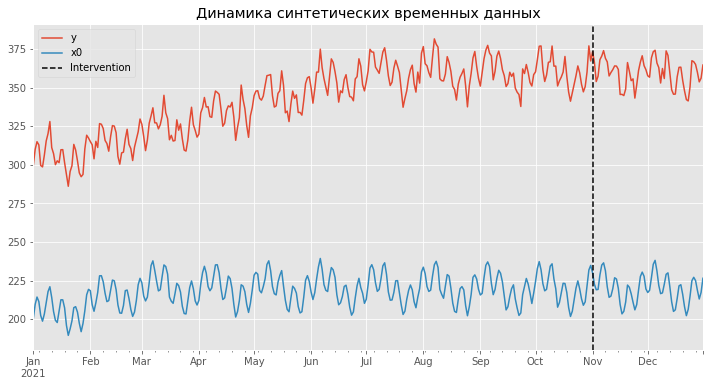

In [ ]:
plt.figure(figsize = (12, 6))
ts_data.y.plot(label = 'y')
ts_data.x0.plot(label = 'x0')
plt.title('Динамика синтетических временных данных')
plt.axvline(x="2021-11-01", color='black', linestyle='--', label='Intervention')
plt.legend();

В динамике можем увидеть, что тренды совпадают вначале и начиная с середины, как и закладывали

p-value тест Дики-Фуллера = 0.689755
Разница между метрикой и ковариатой стационарна во времени? -> False


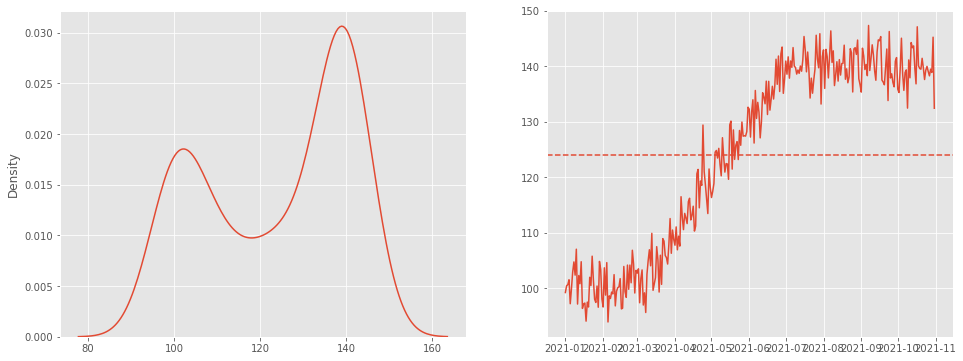

In [ ]:
y_pre = ts_data[ts_data['intervention'] == 0].y
x0_pre = ts_data[ts_data['intervention'] == 0].x0
diff = y_pre - x0_pre
DF_pval = smp.tsa.stattools.adfuller(diff)[1]
print("p-value тест Дики-Фуллера = %f" % DF_pval)
print('Разница между метрикой и ковариатой стационарна во времени? ->', DF_pval < 0.05)
fig,axes = plt.subplots(1, 2, figsize=(16,6))
sns.kdeplot(ax=axes[0], data = diff)
axes[1].plot(diff)
axes[1].axhline(y = np.mean(diff),ls = '--')

Видим, что ряд нестационарен с помощью стат. критерия Дики-Фуллера (принятие нулевой гипотезы за счёт большого p-value) и можем увидеть непараллельные тренды которые мы изначально задали.
Давайте все-таки попробуем провести анализ diff-in-diff несмотря на то, что условия для него не выполняются. И посмотрим, что из этого получится.

In [ ]:
data_w = pd.melt(ts_data.reset_index(), id_vars=['index', 'intervention'], value_vars=['y', 'x0'],
                 var_name='variable', value_name='value')
data_w['treatment'] = np.where(data_w.variable == 'y', 1, 0)

df_s = data_w.pivot_table(values = 'value', index = 'intervention', columns = 'treatment', aggfunc = 'mean')
df_s['diff'] = df_s.iloc[:, 1] - df_s.iloc[:, 0]

diff_in_diff = df_s.iloc[1, -1] - df_s.iloc[0, -1]

print('Diff-in-Diff =', diff_in_diff)
df_s

Diff-in-Diff = 15.741747674823813


treatment,0,1,diff
intervention,,,
0,218.111342,342.223506,124.112164
1,219.882640,359.736552,139.853912


Быстрый взгляд на таблицу говорит, что мы нашли эффект +15,7, там где его быть не болжно. Давайте проверим что скажет модель регрессии. Возможно этот lift не стат. значим.

In [ ]:
formula = 'value ~ treatment + intervention + treatment * intervention'
model = sm.ols(formula = formula, data = data_w)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     3890.
Date:                Mon, 02 Oct 2023   Prob (F-statistic):               0.00
Time:                        15:42:36   Log-Likelihood:                -3052.9
No. Observations:                 730   AIC:                             6114.
Df Residuals:                     726   BIC:                             6132.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                218

Видим стат. значимое изменение, на самом деле которых не было, т.е. получаем ошибку I рода поскольку видим эффект там, где его нет. Это печально(((
Как мы видим, это косвенно указывает, что при не соблюдении параллельности трендов работа метода может выдавать нам ошибочно позитивные результаты. Дальше мы прогоним это через проверку на статзначимость, чтобы оценить FPR.

### 3.2 Давайте теперь попробуем те же данные, но с добавлением эффекта в виде -5%

In [ ]:
ar = np.r_[1, 0.2]
ma = np.array([1])
arma_process = ArmaProcess(ar, ma)
x0 = 100 + arma_process.generate_sample(nsample=365)
rel_effect = -0.05
# Сезонный компонент
# Синусоида для повтора цикла каждые 7 дней, еженедельная сезонность
seasonal_component_weekly = np.sin(2 * np.pi * np.arange(365) / 7) * 10

# Синусоида для повтора цикла каждые 30 дней, еженедельная сезонность
seasonal_component_monthly = np.sin(2 * np.pi * np.arange(365) / 30) * 15

# Меняем наклоны трендов в определенных точках
trend_x0 = np.concatenate([np.linspace(100, 120, 60), np.linspace(120, 120, 305)])
trend_y = np.concatenate([np.linspace(100, 120, 60), np.linspace(120, 140, 60), np.linspace(140, 160, 60), np.linspace(160, 160, 185)])

# эффект не добавляем. АА-реализация
y = 1.9 * x0 + seasonal_component_weekly + seasonal_component_monthly+ trend_y + np.random.normal(10, 3, size=365) # Добавляем сезонные и трендовые компоненты и шум
x0 += seasonal_component_weekly + seasonal_component_monthly+ trend_x0 # Добавляем сезонные и трендовые компоненты

date_range = pd.date_range(start="2021-01-01", periods=365)
ts_data = pd.DataFrame({'y': y, 'x0': x0}, index=date_range)
ts_data['intervention'] = np.where(ts_data.index >= '2021-11-01', 1, 0)
ts_data.loc['2021-11-01':, 'y'] *= (1+rel_effect)# добавляем отрицательный эффект -5%

ts_data.sample(10)

,y,x0,intervention
2021-05-29,352.395592,221.821515,0
2021-11-18,324.724545,197.668056,1
2021-08-20,344.870077,207.386489,0
2021-08-06,377.988993,235.620819,0
2021-08-25,341.797414,198.267704,0
2021-03-30,317.954095,209.480391,0
2021-02-14,335.778815,230.164335,0
2021-08-10,367.817515,227.638197,0
2021-02-08,325.812732,230.910577,0
2021-08-17,347.188917,206.844975,0


Создаем датафрейм похожим до этого, но с добавлением эффекта -5%

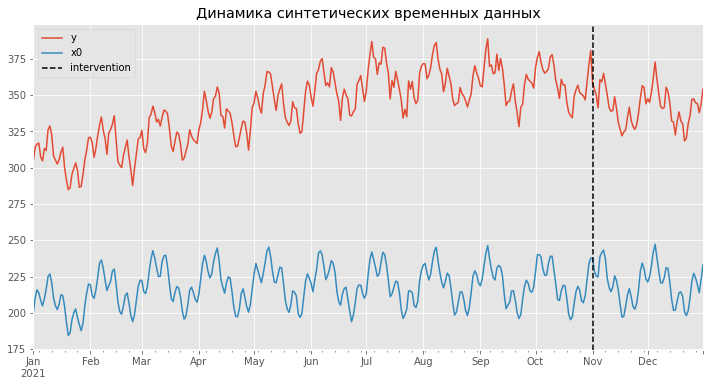

In [ ]:
plt.figure(figsize = (12, 6))
ts_data.y.plot(label = 'y')
ts_data.x0.plot(label = 'x0')
plt.title('Динамика синтетических временных данных')
plt.axvline(x="2021-11-01", color='black', linestyle='--', label='intervention')
plt.legend();

In [ ]:
data_w = pd.melt(ts_data.reset_index(), id_vars=['index', 'intervention'], value_vars=['y', 'x0'],
                 var_name='variable', value_name='value')
data_w['treatment'] = np.where(data_w.variable == 'y', 1, 0)

df_s = data_w.pivot_table(values = 'value', index = 'intervention', columns = 'treatment', aggfunc = 'mean')
df_s['diff'] = df_s.iloc[:, 1] - df_s.iloc[:, 0]

diff_in_diff = df_s.iloc[1, -1] - df_s.iloc[0, -1]
expected_abs_lift = rel_effect * ts_data.loc[ts_pre_period[0]:ts_pre_period[1], 'y'].mean()

print('Expected abs lift =', expected_abs_lift)
print('Diff-in-Diff =', diff_in_diff)
df_s

Expected abs lift = -17.101267260734563
Diff-in-Diff = -1.7087851328388126


treatment,0,1,diff
intervention,,,
0,218.088286,342.025345,123.937059
1,220.066055,342.294329,122.228274


С помощью относительной Diff-in-Diff можем видеть что изменение почти нулевое, это происходит за счёт того, что в истории данные были не параллельные и значения Y были выше. А из-за изменения в -5%, значения условно +5% в истории и -5% после изменения сводятся вместе к нулю

In [ ]:
# посмотрим какой ответ даст нам регрессия
formula = 'value ~ treatment + intervention + treatment * intervention'
model = sm.ols(formula = formula, data = data_w)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     2815.
Date:                Mon, 02 Oct 2023   Prob (F-statistic):               0.00
Time:                        15:46:31   Log-Likelihood:                -3151.6
No. Observations:                 730   AIC:                             6311.
Df Residuals:                     726   BIC:                             6330.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                218

Можем наблюдать с анализа Diff-in-Diff что изменение -5% было хоть и явным на графике, якобы не стат. значимым. Т.е. получаем ошибку II рода.

Теперь давайте попробуем просимулировать множество Diff-in-Diff анализов с различными синтетическими эффектами и оценить ошибку I и II рода. Воспользовуемся функцией о котором будет более детально рассказано в следующей лекции по Causal Impact

# 4. Проверка критерия на мощность и статзначимость

### 4.1 Код для валидации экспериментов зависимых от временного ряда.

- Симуляция экспериментов на временных данных это не тоже самое, что простым бутсрапом извлекать пользователей из исторических данных для каждой симуляции.
-  При симуляциях временого ряда, нужно сохранять корреляцию и патерны зависимости от времени.
- Поэтому здесь одна итерация симуляции - не разрывный, но взятый рандомно период времени. Для наших causal inference методик нужно брать pre и post период. Это мы и будем делат многократно. Рандомно брать pre и post период в заданных границах и смотреть в скольких случаях мы будем получать FP и FN
- По результатам симуляции мы сможем оценить долю FPR и FNR на наших реальных данных. Для causal inference намного важнее оценивать эти ошибки на реально существующих данных, т.к. именно из-за реальных скрытых нарушений и проблем в динамиках эти методики ломаются.

In [ ]:
ts_data.loc['2021-11-01':, 'y'] /= (1 + rel_effect) # Возвращаем данные в прежний вид, без эффектов

In [ ]:
# подготовим функции для такого удобного симулирования pre post разбивки на исторических данных
import joblib

def causal_analysis(data, control_group, n_days = 14, control_percent = 0.7, sample_n = 50):
    '''
    data - наши исторические данные, на которых мы будем прогонять проверку критерия
    control_group - название переменной формирующих контрольную группу
    n_days - количество дней тестового периода. т.е. сколько мы предполагаем будет идти пост-период в днях.
                Задавать нужно так чтобы размер n_days не превышал 1-control_percent долю тестовых данных. Поэтому процент 1-control_percent нужно оставлять с запасом
    control_percent - доля истрических данных, которую мы резервируем для контрольного периода. Например не меньше 70%.
    sample_n - кол-во симмуляций. Сколько раз прогоняем на каждый проверяеммый эффект симмуляции (в коде по умолчанию 7 эффектов)

    '''
    n_days -= 1

    df_copy = data.copy()
    effects = [0.9, 0.95, 0.975, 1., 1.025, 1.05, 1.1] # Эффекты от снижения до увеличения. 1 - эффекта нет = АА вариант
    rel_effects = []

    dates = pd.DataFrame({'post_period_0': data.index}) # Даты

    # Самая первая дата контрольной группы
    initial = dates.values[0][0]
    # Тестовая группа, подбираем из неё sample_n рандомных дат в тестовом периоде, т.е. sample_n дат после control_percent дней.
    # мы как бы рандомно накидываем дни старта нововведения в тестовой зоне
    test = dates.iloc[int(len(dates)*(control_percent)):-n_days]\
                .sample(sample_n, random_state = 123, replace = True)\

    # Определяем пост и пре период в зависимости от полученных рандомных дат в тестовом периоде
    test['post_period_1'] = test.post_period_0 + pd.DateOffset(days = n_days)
    test['pre_period_0'] = initial
    test['pre_period_1'] = test.post_period_0 - pd.DateOffset(days = 1)

    test = test.astype(str)
    a = np.empty((sample_n, len(effects) + 2))

    def calculate_sse_mape_pval(d):
        sse = []
        mape = []
        p_vals = []
        for i in range(len(effects)):
            pre_period = [test.pre_period_0.values[d], test.pre_period_1.values[d]]
            post_period = [test.post_period_0.values[d], test.post_period_1.values[d]]

            # формируем датасеты для оценки эффектов. добавляем нужные эффекты
            df_copy = data.copy() # создаём другую переменную дубликата датафрейма чтобы каждый раз задавать новый эффект

            # указываем когда был intervention
            df_copy['intervention'] = 0
            df_copy.loc[post_period[0]:post_period[1], 'intervention'] = 1

            df_copy.loc[np.logical_and(
                        df_copy.index >= post_period[0], df_copy.index <= post_period[1]), 'y'] *= effects[i] # задаём эффект

            df_copy = pd.melt(df_copy.reset_index(), id_vars = ['index', 'intervention'], value_vars = ['y', control_group],
                 var_name = 'variable', value_name = 'value')
            df_copy['treatment'] = np.where(df_copy.variable == 'y', 1, 0)

            formula = 'value ~ treatment + intervention + treatment * intervention'
            model = sm.ols(formula = formula, data = df_copy)
            res = model.fit()

            b0 = res.params['Intercept']
            b1 = res.params['treatment']
            b2 = res.params['intervention']
            b3 = res.params['treatment:intervention']

            # Понимая как устроен Diff-in-Diff, можем с регрессии вычислить относительное изменение diff-in-diff
            rel_diff_in_diff = ((b0 + b1 + b2 + b3) / (b0 + b1)) / ((b0 + b2) / b0) - 1

            real_eff = effects[i] - 1
            to_sse = pow(rel_diff_in_diff - real_eff, 2) # считаем квадрат ошибок нашего найденного diff-in-diff и реального
            to_mape = abs(rel_diff_in_diff - real_eff) * 100 # считаем квадрат ошибок нашего найденного diff-in-diff и реального

            sse.append(to_sse)
            mape.append(to_mape)
            rel_effects.append(rel_diff_in_diff)
            p_vals.append(res.pvalues['treatment:intervention'])

        return (d, sum(sse), np.mean(mape), p_vals[effects.index(1)], p_vals[effects.index(1.025)],
               p_vals[effects.index(0.975)], p_vals[effects.index(1.05)], p_vals[effects.index(0.95)],
               p_vals[effects.index(1.1)], p_vals[effects.index(0.9)])

    results = joblib.Parallel(n_jobs=-1, verbose = len(test))(joblib.delayed(calculate_sse_mape_pval)(d) for d in range(len(test)))

    for result in results:
        d = result[0]
        a[d][0] = result[1]
        a[d][1] = result[2]
        a[d][2] = result[3]
        a[d][3] = result[4]
        a[d][4] = result[5]
        a[d][5] = result[6]
        a[d][6] = result[7]
        a[d][7] = result[8]
        a[d][8] = result[9]

    aa = pd.DataFrame(a, columns = ['sse', 'mape', 'p_val_1', 'p_val_1_025', 'p_val_0_975',
                                    'p_val_1_05', 'p_val_0_95', 'p_val_1_1', 'p_val_0_9'])
    final = test.reset_index().merge(aa.reset_index(), left_index = True, right_index = True)
    final.drop(columns = ['index_x', 'index_y'], inplace = True)
    final['control_group'] = control_group
    return final

Функция на основе исторических данных, фиксируем определенный процент для исторических данных, рандомно подбираем даты из остальной части задаем синтетические эффекты и проводим анализ Diff-in-Diff

### 4.2 Прогоним симуляцию на "плохих" АА - данных с не параллельными трендами

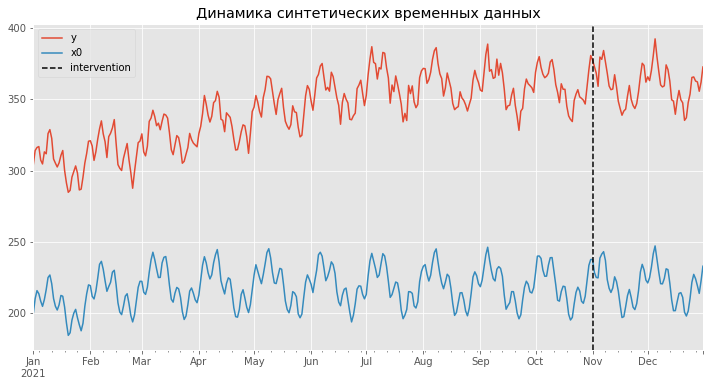

In [ ]:
plt.figure(figsize = (12, 6))
ts_data.y.plot(label = 'y')
ts_data.x0.plot(label = 'x0')
plt.title('Динамика синтетических временных данных')
plt.axvline(x="2021-11-01", color='black', linestyle='--', label='intervention')
plt.legend();

In [ ]:
%%time
n_sim = 500
res = pd.DataFrame()
caus = causal_analysis(ts_data, 'x0', 21, 0.6, n_sim)
res = pd.concat([res, caus], axis = 0)
res

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   

[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 147 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:   13.8s
[Paralle

[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 271 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 273 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 275 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 277 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 278 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 279 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 281 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 282 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 283 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:   20.7s
[Paralle

[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 403 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 404 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 406 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 407 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 408 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 409 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 411 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 412 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 413 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 414 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 415 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 416 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 417 tasks      | elapsed:   28.3s
[Paralle

,post_period_0,post_period_1,pre_period_0,pre_period_1,sse,mape,p_val_1,p_val_1_025,p_val_0_975,p_val_1_05,p_val_0_95,p_val_1_1,p_val_0_9,control_group
0,2021-11-25,2021-12-15,2021-01-01,2021-11-24,0.006044,2.933009,0.011200,0.000042,0.335778,1.744960e-08,0.537179,6.461565e-18,0.000169,x0
1,2021-10-13,2021-11-02,2021-01-01,2021-10-12,0.015484,4.694399,0.018976,0.000126,0.397729,1.128003e-07,0.509563,3.153673e-16,0.000256,x0
2,2021-11-08,2021-11-28,2021-01-01,2021-11-07,0.016544,4.852488,0.015636,0.000094,0.359684,7.541184e-08,0.554938,1.700337e-16,0.000331,x0
3,2021-11-14,2021-12-04,2021-01-01,2021-11-13,0.013461,4.377019,0.018508,0.000117,0.397498,9.753439e-08,0.504139,2.220048e-16,0.000231,x0
4,2021-11-18,2021-12-08,2021-01-01,2021-11-17,0.009962,3.765426,0.011484,0.000050,0.324094,2.651635e-08,0.574444,2.036350e-17,0.000268,x0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2021-08-11,2021-08-31,2021-01-01,2021-08-10,0.017290,4.960562,0.015599,0.000094,0.357935,7.678892e-08,0.559011,1.788775e-16,0.000346,x0
496,2021-11-11,2021-12-01,2021-01-01,2021-11-10,0.016835,4.894944,0.015356,0.000091,0.355949,7.315792e-08,0.560136,1.637483e-16,0.000342,x0
497,2021-11-21,2021-12-11,2021-01-01,2021-11-20,0.006825,3.116605,0.012904,0.000055,0.355035,2.667807e-08,0.520650,1.475134e-17,0.000169,x0
498,2021-11-07,2021-11-27,2021-01-01,2021-11-06,0.015971,4.767689,0.015587,0.000092,0.360216,7.338974e-08,0.552728,1.593078e-16,0.000321,x0


ts_data - данные, x0 - контрольная группа, 14 - кол-во дней для анализа эффекта, 70 - минимальный % для исторических данных, 100 - кол-во симуляции.

В итоге получаем 50 * кол-во эффектов = 100 * 7 = 350 симуляции Diff-in-Diff

Эффекты - +10%, +0%, ...

In [ ]:
#напишем функцию, которая удобно аггрегирует результаты симуляций
def to_res(data, to_group, n, alpha = 0.05): # Указываем уровень значимости = 0.05
    def p_val_count_alpha(p_val):
        return np.count_nonzero(p_val < alpha) # Подсчет ошибки I рода

    def p_val_count_beta(p_val):
        return np.count_nonzero(p_val >= alpha) # Подсчет ошибки II рода

    p_val_cols = data.filter(like = 'p_val').columns

    data['pre_period_diff'] = (pd.to_datetime(data.pre_period_1) - pd.to_datetime(data.pre_period_0))
    res = data.groupby([to_group]).agg({'sse': 'sum', # Sum of Squared Errors
                                     'mape': 'mean', # Mean Absolute Percentage Error
                                     p_val_cols[0]: p_val_count_alpha, # Ошибка I рода в кол-ве
                                     p_val_cols[1]: p_val_count_beta, # Ошидка II рода в кол-ве отсюда и дальше по эффектам
                                     p_val_cols[2]: p_val_count_beta,
                                     p_val_cols[3]: p_val_count_beta,
                                     p_val_cols[4]: p_val_count_beta,
                                     p_val_cols[5]: p_val_count_beta,
                                     p_val_cols[6]: p_val_count_beta,
                                     'pre_period_diff': 'mean'})

    res[p_val_cols[0]] = res[p_val_cols[0]] / n # Делим на кол-во симуляции = 50
    res[p_val_cols[1]] = res[p_val_cols[1]] / n
    res[p_val_cols[2]] = res[p_val_cols[2]] / n
    res[p_val_cols[3]] = res[p_val_cols[3]] / n
    res[p_val_cols[4]] = res[p_val_cols[4]] / n
    res[p_val_cols[5]] = res[p_val_cols[5]] / n
    res[p_val_cols[6]] = res[p_val_cols[6]] / n

    return res

Расчёт ошибок I и II рода в зависимости от кол-ва симуляции

In [ ]:
# проведем оценку стат.значимости и мощности по 100 симуляциям
res_conc = to_res(res, 'control_group', n_sim)
res_conc

,sse,mape,p_val_1,p_val_1_025,p_val_0_975,p_val_1_05,p_val_0_95,p_val_1_1,p_val_0_9,pre_period_diff
control_group,,,,,,,,,,
x0,5.366018,3.828232,1.0,0.0,1.0,0.0,1.0,0.0,0.0,282 days 20:49:55.200000


Получаем датафрейм с контрольной группой, ошибками sse и mape расчитанных на основе реального относительного и выданного моделью регрессией относительного эффекта. А так же ошибки I рода при p_val_1 (без эффекта) и ошибки II рода для разного вида эффектов (+5% - p_val_1_05, -5% - p_val_0_95, ... ), а так же среднее кол-во дней исторических данных для анализа эффектов.

Видим, что ошибки первого и второго рода сильно скачут. Ошибка I рода на 25 симуляциях равна 1, как и ошибка II рода для эффекта -5%

### 4.3 Прогоним симуляцию на плохих данных с "хорошими" параллельными трендами

In [ ]:
np.random.seed(52)

ar = np.r_[1, 0.2]
ma = np.array([1])
arma_process = ArmaProcess(ar, ma)

# Сезонный компонент
# Синусоида для повтора цикла каждые 7 дней, еженедельная сезонность
seasonal_component_weekly = np.sin(2 * np.pi * np.arange(365) / 7)*1.2

# Синусоида для повтора цикла каждые 30 дней, еженедельная сезонность
seasonal_component_monthly = np.sin(2 * np.pi * np.arange(365) / 30)*3

x0 = 100 + arma_process.generate_sample(nsample=365) + seasonal_component_weekly + seasonal_component_monthly
y = 1.9 * x0 + np.random.normal(size=365) + seasonal_component_weekly + seasonal_component_monthly
data = pd.DataFrame({'x0': x0, 'y': y}, columns=['y', 'x0'])

date_range = pd.date_range(start="2021-01-01", periods = 365)
ts_data = data.copy()
ts_data.index = date_range

ts_pre_period = [pd.to_datetime(date) for date in ["2021-01-01", "2021-10-31"]]
ts_post_period = [pd.to_datetime(date) for date in ["2021-11-01", "2021-12-31"]]

#ts_data.loc[ts_post_period[0]:ts_post_period[1], 'y'] *= 1.03 # добавляем эффект

ts_data['intervention'] = 0
ts_data.loc[ts_post_period[0]:ts_post_period[1], 'intervention'] = 1

ts_data.sample(10)

,y,x0,intervention
2021-09-06,202.106875,105.032679,0
2021-06-20,187.035157,99.982138,0
2021-11-27,194.924676,101.880645,1
2021-01-14,191.869281,100.810920,0
2021-09-08,196.406476,102.716605,0
2021-01-01,191.386832,100.519476,0
2021-02-14,197.771008,102.378937,0
2021-06-22,178.148748,96.759040,0
2021-04-24,182.444394,97.685620,0
2021-04-07,200.032172,104.322394,0


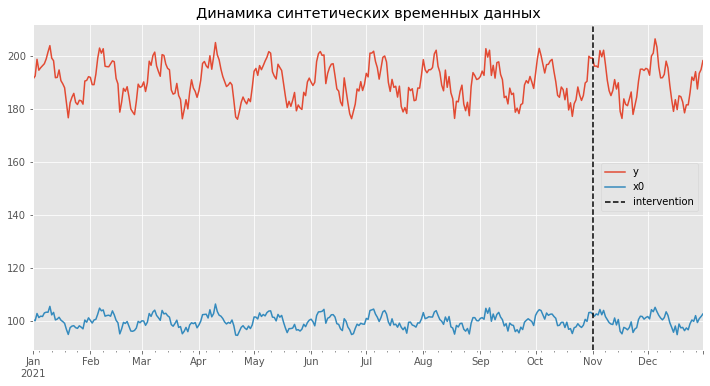

In [ ]:
plt.figure(figsize = (12, 6))
ts_data.y.plot(label = 'y')
ts_data.x0.plot(label = 'x0')
plt.title('Динамика синтетических временных данных')
plt.axvline(x="2021-11-01", color='black', linestyle='--', label='intervention')
plt.legend();

p-value тест Дики-Фуллера = 0.000344
Разница между метрикой и ковариатой стационарна во времени? -> True


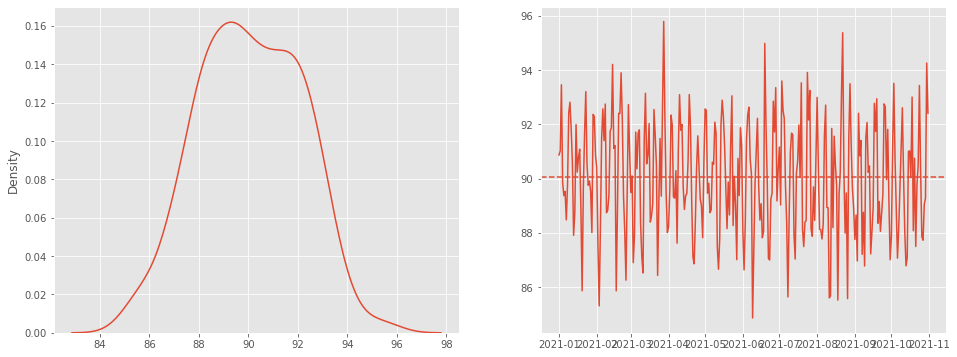

In [ ]:
y_pre = ts_data[ts_data['intervention'] == 0].y
x0_pre = ts_data[ts_data['intervention'] == 0].x0
diff = y_pre - x0_pre
DF_pval = smp.tsa.stattools.adfuller(diff)[1]
print("p-value тест Дики-Фуллера = %f" % DF_pval)
print('Разница между метрикой и ковариатой стационарна во времени? ->', DF_pval < 0.05)
fig,axes = plt.subplots(1, 2, figsize=(16,6))
sns.kdeplot(ax=axes[0], data = diff)
axes[1].plot(diff)
axes[1].axhline(y = np.mean(diff),ls = '--')

In [ ]:
# прогоняем через симуляции разных эффектов
res = pd.DataFrame()
n_sim = 500
caus = causal_analysis(ts_data, 'x0', 3, 0.5, n_sim)
res = pd.concat([res, caus], axis = 0)
res

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   

[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 147 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:    7.8s
[Paralle

[Parallel(n_jobs=-1)]: Done 267 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 271 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 273 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 275 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 277 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 278 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 279 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 281 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 282 tasks      | elapsed:   13.7s
[Paralle

[Parallel(n_jobs=-1)]: Done 403 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 404 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 406 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 407 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 408 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 409 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 411 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 412 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 413 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 414 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 415 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 416 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 417 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   19.5s
[Paralle

,post_period_0,post_period_1,pre_period_0,pre_period_1,sse,mape,p_val_1,p_val_1_025,p_val_0_975,p_val_1_05,p_val_0_95,p_val_1_1,p_val_0_9,control_group
0,2021-10-19,2021-10-21,2021-01-01,2021-10-18,0.002889,2.027722,0.101297,0.562241,0.007061,0.630606,0.000182,9.438426e-03,6.092307e-09,x0
1,2021-11-05,2021-11-07,2021-01-01,2021-11-04,0.003383,2.194115,0.073725,0.002976,0.547701,0.000034,0.556757,1.100097e-10,3.107706e-03,x0
2,2021-09-06,2021-09-08,2021-01-01,2021-09-05,0.000846,1.097414,0.299090,0.028392,0.906028,0.000840,0.202560,2.100985e-08,3.522294e-04,x0
3,2021-10-08,2021-10-10,2021-01-01,2021-10-07,0.001730,1.569225,0.213604,0.016296,0.934843,0.000379,0.279945,5.676357e-09,6.921834e-04,x0
4,2021-07-19,2021-07-21,2021-01-01,2021-07-18,0.002259,1.792898,0.216305,0.870100,0.021083,0.363038,0.000748,2.316067e-03,4.362772e-08,x0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2021-08-04,2021-08-06,2021-01-01,2021-08-03,0.000715,1.008917,0.430841,0.053853,0.722864,0.002190,0.134636,1.118746e-07,1.672690e-04,x0
496,2021-08-05,2021-08-07,2021-01-01,2021-08-04,0.001485,1.453762,0.262304,0.022973,0.971994,0.000625,0.233599,1.322092e-08,4.822586e-04,x0
497,2021-09-03,2021-09-05,2021-01-01,2021-09-02,0.001476,1.449343,0.206343,0.015303,0.921499,0.000344,0.285962,4.736580e-09,7.080847e-04,x0
498,2021-07-14,2021-07-16,2021-01-01,2021-07-13,0.000003,0.060213,0.852772,0.359113,0.197821,0.043657,0.016996,2.666847e-05,5.006036e-06,x0


In [ ]:
res_conc = to_res(res, 'control_group', n_sim)
res_conc

,sse,mape,p_val_1,p_val_1_025,p_val_0_975,p_val_1_05,p_val_0_95,p_val_1_1,p_val_0_9,pre_period_diff
control_group,,,,,,,,,,
x0,0.483128,1.004457,0.004,0.702,0.79,0.428,0.426,0.0,0.0,269 days 12:28:48


# 5. Реальный кейс на подачу в классифайде

Мы захотели увеличить подачу объявлений в классифайде. для проверки эффекте не делали АБ. А раскатили на одну платформу (android) и хотим IOS использовать как ковариату (тестовую группу).

### 5.1 выгрузим данные

In [ ]:
from clickhouse_driver import Client

In [ ]:
client = Client(host='clickhouse.lab.karpov.courses', port=9000, user='d-kazakov', password='your_password', database='hardda')

In [ ]:
def get_data(query):
    """
    Вытягивает данные из clickhouse в виде Dataframe

    query - запрос
    """
    result, columns = client.execute(query,with_column_types=True)
    return pd.DataFrame(result, columns=[tuple[0] for tuple in columns])

In [ ]:
query = """
SELECT
    event_date
    , platform
    , SUM(cnt_successful_new_advertisement_creation) AS sum_success_new_ads
FROM
    user_dm_events
WHERE
    event_date BETWEEN '2022-01-01' AND '2022-04-30'
GROUP BY
    event_date
    , platform
"""

data = get_data(query)

Выгружаем данные по витрине событии user_dm_events по кол-ву успешно созданных объявлении в разрезе платформ за первые 4 месяца 2022 года

In [ ]:
data.to_csv('platform_new_ads.csv')

In [ ]:
data = pd.read_csv('platform_new_ads.csv', index_col = 0, parse_dates = ['event_date'])\
         .sort_values(by = ['event_date', 'platform']).reset_index(drop = True)

data['intervention'] = np.where(data.event_date >= '2022-04-18', 1, 0)
data['treatment'] = np.where(data.platform == 'android', 1, 0)
data

,event_date,platform,sum_success_new_ads,intervention,treatment
0,2022-02-01,android,3376,0,1
1,2022-02-01,ios,1375,0,0
2,2022-02-02,android,3282,0,1
3,2022-02-02,ios,1352,0,0
4,2022-02-03,android,3259,0,1
...,...,...,...,...,...
173,2022-04-28,ios,1443,1,0
174,2022-04-29,android,3092,1,1
175,2022-04-29,ios,1353,1,0
176,2022-04-30,android,3212,1,1


Задаем значения intervention с 2022-04-18 даты и в качестве тестовой группой = android, контрольная = ios

### 5.2 Визуализация

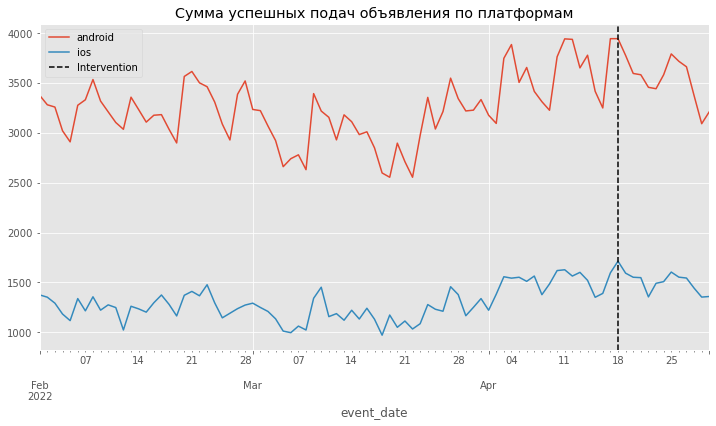

In [ ]:
plt.title('Сумма успешных подач объявления по платформам')
data.set_index('event_date').groupby(['platform']).sum_success_new_ads.plot(figsize = (12, 6))
plt.axvline(x = '2022-04-18', color = 'black', linestyle = '--', label = 'Intervention')
plt.legend();

Смотрим в динамике на изменение метрики кол-ва успешных подач объявления по платформам, метрики по платформам ведут себя схожи до и после изменения

### 5.3 Проверка на параллельность трендов

p-value тест Дики-Фуллера = 0.761359
Разница между метрикой и ковариатой стационарна во времени? -> False


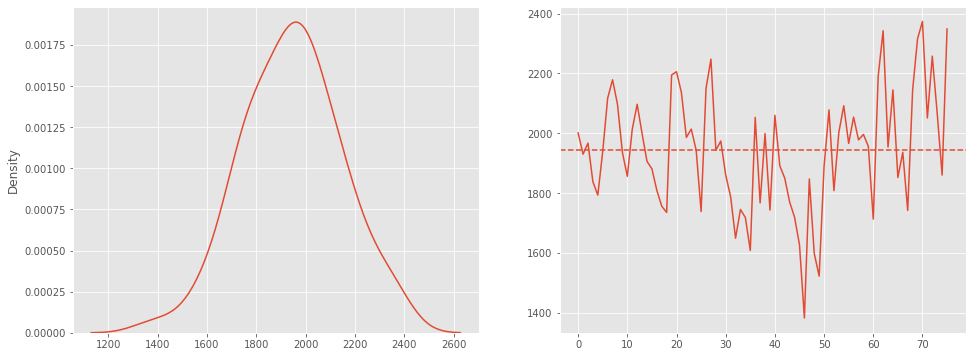

In [ ]:
y_pre = np.array(data[(data['intervention'] == 0) & (data['platform'] == 'android')].sum_success_new_ads)
x0_pre = np.array(data[(data['intervention'] == 0) & (data['platform'] == 'ios')].sum_success_new_ads)
diff = y_pre - x0_pre
DF_pval = smp.tsa.stattools.adfuller(diff)[1]
print("p-value тест Дики-Фуллера = %f" % DF_pval)
print('Разница между метрикой и ковариатой стационарна во времени? ->', DF_pval < 0.05)
fig,axes = plt.subplots(1, 2, figsize=(16,6))
sns.kdeplot(ax=axes[0], data = diff)
axes[1].plot(diff)
axes[1].axhline(y = np.mean(diff),ls = '--')

In [ ]:
df_s_r = data.pivot_table(values = 'sum_success_new_ads', index = 'intervention', columns = 'treatment', aggfunc = 'mean')
df_s_r['diff'] = df_s_r.iloc[:, 1] - df_s_r.iloc[:, 0]

diff_in_diff_r = df_s_r.iloc[1, -1] - df_s_r.iloc[0, -1]

print('Diff-in-Diff =', diff_in_diff_r)
df_s_r

Diff-in-Diff = 104.29959514170037


treatment,0,1,diff
intervention,,,
0,1285.934211,3229.250000,1943.315789
1,1508.923077,3556.538462,2047.615385


Можем увидеть абсолютное изменение +104 кол-ва новых подач, попробуем оценить стат. значимость этого изменения

In [ ]:
formula = 'sum_success_new_ads ~ treatment + intervention + treatment * intervention'
model = sm.ols(formula = formula, data = data)
res = model.fit()
print(res.summary())

                             OLS Regression Results                            
Dep. Variable:     sum_success_new_ads   R-squared:                       0.940
Model:                             OLS   Adj. R-squared:                  0.939
Method:                  Least Squares   F-statistic:                     915.5
Date:                 Mon, 02 Oct 2023   Prob (F-statistic):          2.78e-106
Time:                         17:13:17   Log-Likelihood:                -1233.8
No. Observations:                  178   AIC:                             2476.
Df Residuals:                      174   BIC:                             2488.
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept         

Как можем видеть, p-value = 0.328 чем можно принять нулевую гипотезу

Теперь попробуем оценить ошибки I и II рода на симуляциях

In [ ]:
ts_data = data.query("event_date < '2022-04-18'")\
              .pivot_table(values = 'sum_success_new_ads', index = 'event_date', columns = 'platform')
ts_data.rename(columns = {'android': 'y'}, inplace = True)
ts_data.index.name = None
ts_data

platform,y,ios
2022-02-01,3376,1375
2022-02-02,3282,1352
2022-02-03,3259,1292
2022-02-04,3021,1183
2022-02-05,2910,1117
...,...,...
2022-04-13,3652,1601
2022-04-14,3779,1521
2022-04-15,3417,1351
2022-04-16,3250,1390


Преобразовываем данные в нужный нам формат

In [ ]:
%%time
res = pd.DataFrame()
caus = causal_analysis(ts_data, 'ios', 10, 0.6, 100)
res = pd.concat([res, caus], axis = 0)
res

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   

,post_period_0,post_period_1,pre_period_0,pre_period_1,sse,mape,p_val_1,p_val_1_025,p_val_0_975,p_val_1_05,p_val_0_95,p_val_1_1,p_val_0_9,control_group
0,2022-03-31,2022-04-09,2022-02-01,2022-03-30,0.032369,6.787408,0.705811,0.277072,0.736708,0.073699,0.293514,0.001605,0.013679,ios
1,2022-03-20,2022-03-29,2022-02-01,2022-03-19,0.005215,2.724485,0.591496,0.930476,0.245570,0.478933,0.074467,0.053554,0.002585,ios
2,2022-03-20,2022-03-29,2022-02-01,2022-03-19,0.005215,2.724485,0.591496,0.930476,0.245570,0.478933,0.074467,0.053554,0.002585,ios
3,2022-03-24,2022-04-02,2022-02-01,2022-03-23,0.000153,0.466745,0.846638,0.400675,0.649079,0.138011,0.270395,0.006032,0.017241,ios
4,2022-04-04,2022-04-13,2022-02-01,2022-04-03,0.039595,7.506831,0.130753,0.019791,0.497666,0.001745,0.870564,0.000003,0.065015,ios
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2022-04-01,2022-04-10,2022-02-01,2022-03-31,0.039933,7.538850,0.597011,0.208014,0.835741,0.047728,0.344661,0.000728,0.016013,ios
96,2022-03-24,2022-04-02,2022-02-01,2022-03-23,0.000153,0.466745,0.846638,0.400675,0.649079,0.138011,0.270395,0.006032,0.017241,ios
97,2022-04-06,2022-04-15,2022-02-01,2022-04-05,0.029623,6.493055,0.131171,0.020965,0.485565,0.002002,0.902526,0.000005,0.077942,ios
98,2022-03-24,2022-04-02,2022-02-01,2022-03-23,0.000153,0.466745,0.846638,0.400675,0.649079,0.138011,0.270395,0.006032,0.017241,ios


Воспользуемся функцией симуляции, оставим 60% минимальной пре-период и сделаем для 25 дат 25 * 7 = 175 симуляции в общем, или же 25 симуляции для каждого эффекта с помощью Diff-in-Diff для анализа пост-периода в длиной 7 дней

In [ ]:
res_conc = to_res(res, 'control_group', 100)
res_conc

,sse,mape,p_val_1,p_val_1_025,p_val_0_975,p_val_1_05,p_val_0_95,p_val_1_1,p_val_0_9,pre_period_diff
control_group,,,,,,,,,,
ios,1.635137,3.9926,0.0,0.78,0.95,0.44,0.9,0.17,0.23,54 days 04:48:00


Можем увидеть ошибку I рода в районе 0.04, и ошибку II рода для разного вида эффектов, например для +5% она составляет 0.72, а для эффекта +10% - 0.2. В среднем использовалось для симуляции около 56 дней пре-периода